# Porto Daily Trips

In this exercise we are going to use (beloved!) Porto taxi ride database 


In [1]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from sklearn.metrics import accuracy_score,mean_squared_error
import matplotlib.ticker as ticker
from statsmodels.tsa.stattools import adfuller

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import csv
import json
from zipfile import ZipFile
import geopy.distance
import numpy as np 
import tqdm as tqdm_notebook
import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Q1 - Data Preparation - Daily trips to Dataframe

First use sqlite3 library to connect to your .db file. 

Afterwards create a query that counts *daily taxi rides*. *Hint:* use "group by" close on start_ts field that is formatted by day of year

Finally insert the results of the query into a dataframe

In [3]:
DB_NAME = 'my_trip.db'

#display info about the tbl
with sqlite3.connect(DB_NAME) as con:
    cur = con.cursor()
    cur.execute('PRAGMA table_info(trips);')
    con.commit()
    [print(row) for row in cur.fetchall()]
    cur.close()


(0, 'trip_id', 'INTEGER', 0, None, 1)
(1, 'taxi_id', 'INTEGER', 0, None, 0)
(2, 'day_type', 'CHAR(1)', 0, None, 0)
(3, 'missing_data', 'BOLLEAN', 0, None, 0)
(4, 'start_ts', 'INTEGER', 0, None, 0)
(5, 'start_year', 'INTEGER', 0, None, 0)
(6, 'start_month', 'INTEGER', 0, None, 0)
(7, 'start_day', 'INTEGER', 0, None, 0)
(8, 'start_hour', 'INTEGER', 0, None, 0)
(9, 'nb_points', 'INTEGER', 0, None, 0)
(10, 'dist_km', 'FLOAT', 0, None, 0)
(11, 'is_birthday', 'BOOLEAN', 0, None, 0)
(12, 'is_before_13', 'BOOLEAN', 0, None, 0)
(13, 'start_dow', 'CHAR(10)', 0, None, 0)
(14, 'start_doy', 'VARCHAR', 0, None, 0)


In [4]:
with sqlite3.connect(DB_NAME) as con:
    
    daily_rides = pd.read_sql_query('''SELECT Cast(strftime('%j', start_ts, 'unixepoch') as INT) as day,
                                            COUNT(taxi_id) as rides_count 
                                            FROM trips 
                                            GROUP BY day''',con)
   
daily_rides

,day,rides_count
0,1,7036
1,2,4285
2,3,3965
3,4,3851
4,5,3455
...,...,...
360,361,4432
361,362,4398
362,363,3999
363,364,4331


# Q2 - Stationary Time Series

Using Augmented Dickey-Fuller test determine if the series is stationary. What is the p_value?

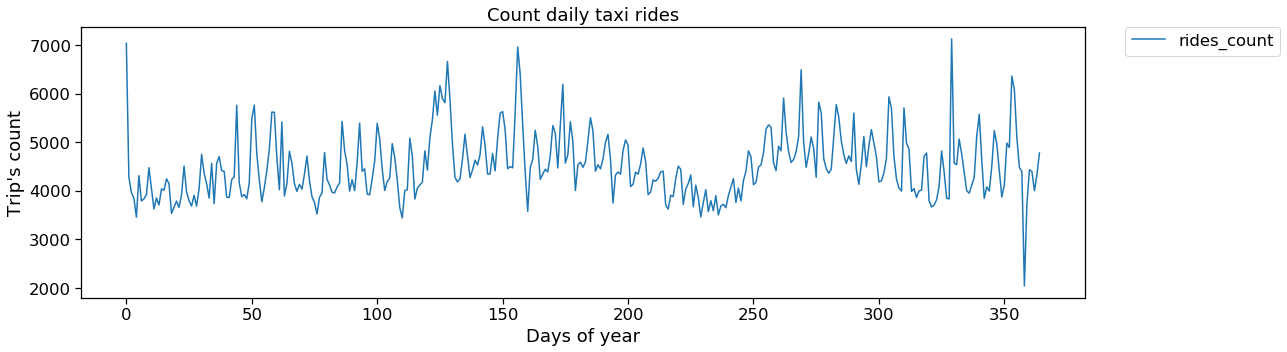

In [5]:
fig = plt.figure(figsize = (18,5))
plt.plot(daily_rides.rides_count, label='rides_count')

plt.title('Count daily taxi rides')
plt.xlabel("Days of year")
plt.ylabel("Trip's count")
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.);


There is no visible trend

In [6]:
class StationarityTests:
    '''class which implements the ADF test from the statsmodels python package'''
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], 
                                  index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [7]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(daily_rides.rides_count, printResults = True)
print(f"Is the time series stationary? {sTest.isStationary}")

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.939928
P-Value                   0.040898
# Lags Used              13.000000
# Observations Used     351.000000
Critical Value (1%)      -3.449119
Critical Value (5%)      -2.869810
Critical Value (10%)     -2.571176
dtype: float64
Is the time series stationary? True


As you would expect, the results show that the series is actually stationary. In this case, the P-Value from our ADF test is much smaller than our 5% significance level, therefore we can reject the Null hypothesis and instead accept the alternate hypothesis that stationarity exists.
<br>Taking a look at the critical value yields the same conclusion. The tests critical value ends up being -2.944622 which is smaller than the 5% critical value of -2.869810 and so we have enough evidence to conclude that unit root does not exist. In other words, the series is stationary.

# Q3 - Rolling (Moving) Average

Calculate the rolling average over last 30 days, plot it on top of daily ride distribution graph.

In [8]:
daily_rides['rolling_avg_30'] = daily_rides.iloc[:,1].rolling(window=30).mean()


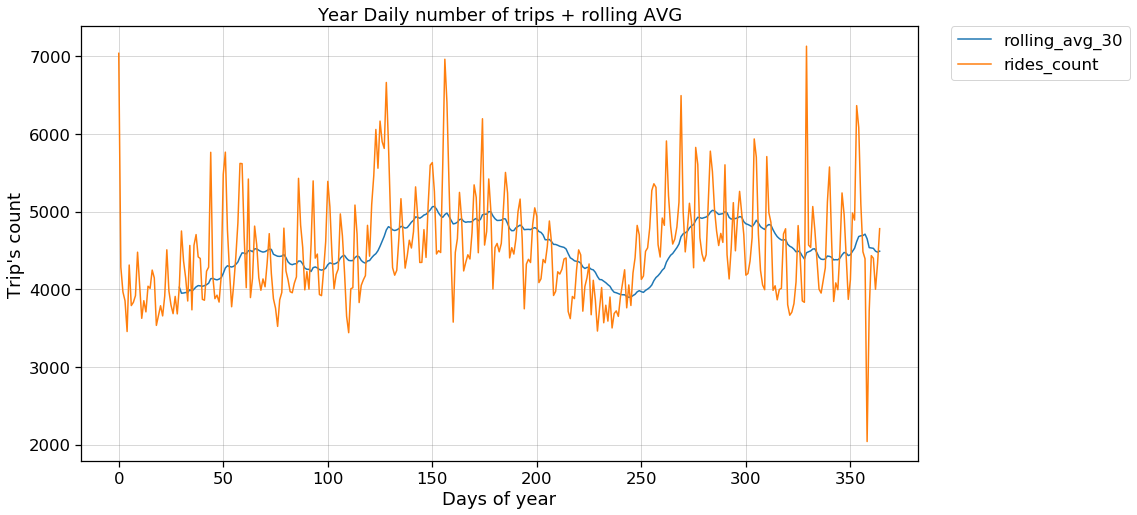

In [9]:
fig, ax = plt.subplots(figsize=(15,8))

plt.plot(daily_rides.rolling_avg_30,  label='rolling_avg_30')
plt.plot(daily_rides.rides_count, label='rides_count')
plt.title('Year Daily number of trips + rolling AVG')
plt.xlabel("Days of year")
plt.ylabel("Trip's count")
ax.grid( color='grey', alpha=0.3)
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', borderaxespad=0.);

# Q4.i. - Determine Seasonality

Using daily rides dataframe, plot an Auto-Correlation graph. Is there a seasonality? If so what is the seasonality factor? Why?

Hint:
from statsmodels.graphics.tsaplots import plot_acf


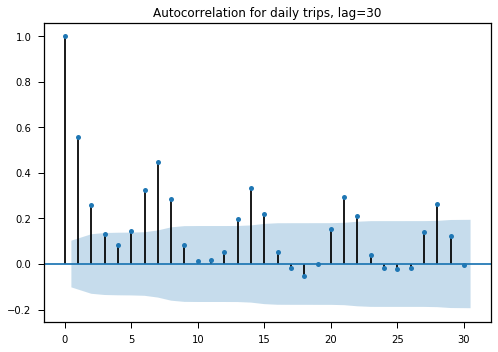

In [10]:

plt.style.use('seaborn-notebook')


# Display the autocorrelation plot of our time series
fig = tsaplots.plot_acf(daily_rides.rides_count.dropna(), lags=30,title='Autocorrelation for daily trips, lag=30');


##### Is there a seasonality? 

Yes there is a seasonality
<br>As we can see, there are several spikes above the blue region, meaning there are correlations at lags 0,1, 2, 6,7,8,14,15,16,21,22 and 28.
<br>Looks like a weekly seasonality

##### If so what is the seasonality factor? 

In time series data, seasonality refers to the presence of variations which occur at certain regular intervals either on a weekly basis, monthly basis, or even quarterly but never up to a year. Various factors may cause seasonality like a vacation, weather, and holidays and comprise repetitive, periodic, and generally regular and patterns that are predictable in a time series level.

##### Why?

If autocorrelation values are close to 0, then values between consecutive observations are not correlated with one another. Inversely, autocorrelations values close to 1 or -1 indicate that there exists strong positive or negative correlations between consecutive observations, respectively.

In order to help us asses how trustworthy these autocorrelation values are, the plot_acf() function also returns confidence intervals (represented as blue shaded regions). If an autocorrelation value goes beyond the confidence interval region, we can assume that the observed autocorrelation value is statistically significant.

# Q4.ii. - Smoothing

**Plot 2 AutoCorellation graphs:**

#### a.Graph of rolling average of 30 days



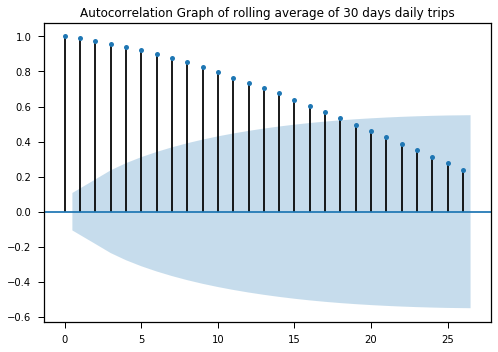

In [12]:
fig = tsaplots.plot_acf(daily_rides.rolling_avg_30.dropna(),title='Autocorrelation Graph of rolling average of 30 days daily trips');

#### b. Graph of rolling average of the seasonality factor you found before.


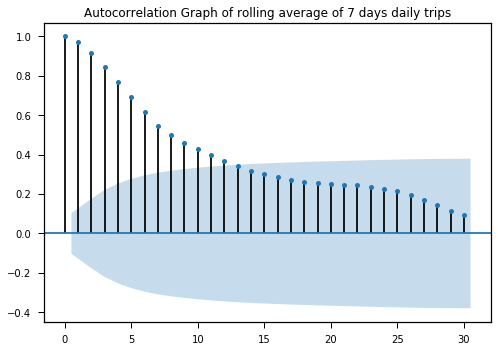

In [13]:
daily_rides['rolling_avg_7'] = daily_rides.iloc[:,1].rolling(window=7).mean()
fig = tsaplots.plot_acf(daily_rides.rolling_avg_7.dropna(), lags=30,title='Autocorrelation Graph of rolling average of 7 days daily trips');



#### C. Graph of rolling average of 3 days


In [14]:
daily_rides['rolling_avg_3'] = daily_rides.iloc[:,1].rolling( window=3).mean()

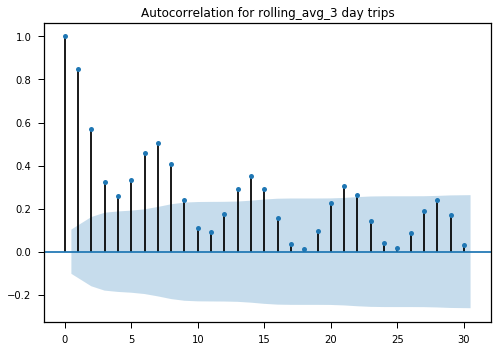

In [15]:
fig = tsaplots.plot_acf(daily_rides.rolling_avg_3.dropna(), lags=30,title='Autocorrelation for rolling_avg_3 day trips');



#### What is the conclusion from the plots?


We see that rolling_avg  ensures that variations in the mean are aligned with the variations in the data rather than being shifted in time
<br>One characteristic of the rolling_avg is that if the data have a periodic fluctuation, then applying an rolling_avg of that period will eliminate that variation (the average always containing one complete cycle). 
<br>In our case the rolling average of 3 days doesn't remove the seasonality factor, but rolling average 7 and 30 day really remove it

# Q5.i. - Autoregression data preperation

**Create a table such that for each day, the previous k day values are in the row (just as in the class exercise).** 

In [16]:
def auto_corr_date_prep(df, k):
    for i in range(1, k+1):
        new_name = f'shifted_{i}'
        df[new_name] = df['rides_count'].shift(i)
    return df

 **Choose k to be larger than 20**

In [17]:
df = auto_corr_date_prep(daily_rides, 25)

**Discard rows with missing history (first ones).**

In [18]:
df.dropna(inplace=True)
df.drop(columns=['rolling_avg_30','rolling_avg_7','rolling_avg_3'],inplace=True)
df

,day,rides_count,shifted_1,shifted_2,shifted_3,shifted_4,shifted_5,shifted_6,shifted_7,shifted_8,...,shifted_16,shifted_17,shifted_18,shifted_19,shifted_20,shifted_21,shifted_22,shifted_23,shifted_24,shifted_25
29,30,4041,3682.0,3907.0,3685.0,3794.0,3976.0,4507.0,3913.0,3656.0,...,3708.0,3852.0,3625.0,4050.0,4476.0,3917.0,3831.0,3789.0,4311.0,3455.0
30,31,4749,4041.0,3682.0,3907.0,3685.0,3794.0,3976.0,4507.0,3913.0,...,4038.0,3708.0,3852.0,3625.0,4050.0,4476.0,3917.0,3831.0,3789.0,4311.0
31,32,4363,4749.0,4041.0,3682.0,3907.0,3685.0,3794.0,3976.0,4507.0,...,4011.0,4038.0,3708.0,3852.0,3625.0,4050.0,4476.0,3917.0,3831.0,3789.0
32,33,4148,4363.0,4749.0,4041.0,3682.0,3907.0,3685.0,3794.0,3976.0,...,4246.0,4011.0,4038.0,3708.0,3852.0,3625.0,4050.0,4476.0,3917.0,3831.0
33,34,3848,4148.0,4363.0,4749.0,4041.0,3682.0,3907.0,3685.0,3794.0,...,4146.0,4246.0,4011.0,4038.0,3708.0,3852.0,3625.0,4050.0,4476.0,3917.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,361,4432,3720.0,2039.0,4392.0,4482.0,5096.0,6082.0,6363.0,4890.0,...,3993.0,4081.0,3842.0,4640.0,5573.0,5121.0,4275.0,4115.0,3950.0,4000.0
361,362,4398,4432.0,3720.0,2039.0,4392.0,4482.0,5096.0,6082.0,6363.0,...,4499.0,3993.0,4081.0,3842.0,4640.0,5573.0,5121.0,4275.0,4115.0,3950.0
362,363,3999,4398.0,4432.0,3720.0,2039.0,4392.0,4482.0,5096.0,6082.0,...,5239.0,4499.0,3993.0,4081.0,3842.0,4640.0,5573.0,5121.0,4275.0,4115.0
363,364,4331,3999.0,4398.0,4432.0,3720.0,2039.0,4392.0,4482.0,5096.0,...,4961.0,5239.0,4499.0,3993.0,4081.0,3842.0,4640.0,5573.0,5121.0,4275.0


**Split the data half way to train and test (first months train, later is test).**

In [19]:
X=df.iloc[:,2:]
y = df.rides_count

X_train = X.iloc[: (len(df)//2), :]
X_test  = X.iloc[len(df)//2:len(df), :]
y_train, y_test = np.array(y[:(len(df)//2)]), np.array(y[len(df)//2:(len(df))])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((168, 25), (168, 25), (168,), (168,))

In [20]:
print(f'Splited  dataset into a 2 sets : \
      \nTrain set is:{round(len(X_train)/len(df)*100,2)}% \
      \nTest set is:{round(len(X_test)/len(df)*100, 2)}%')

Splited  dataset into a 2 sets :       
Train set is:50.0%       
Test set is:50.0%



# Q5.ii. Fit an autocorrelation model

Try to train a linear regression model for different set of features (i.e. {Xt-1},{Xt-1,Xt-2},{Xt-1,Xt-2,Xt-3},...,
{Xt-1,Xt-2,Xt-3,...,Xt-max_lag}) and report scores. For which set of features do you get the best score? keep it and print it coeefcients and intercept


In [21]:
score = []
num = range(1,X_train.shape[1])
for i in num:
    X_i = X_train.iloc[:, :i]
    X_i_test = X_test.iloc[:, :i]
    model = LinearRegression()
    model.fit(X_i, y_train)
    y_pred = model.predict(X_i_test)
    acc_score = 1-model.score(X_i_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    
    score.append(acc_score)
    print(f'Linear Regression with {i} shifted columns. Score: {round(acc_score,3)}, MSE: {round(mse,2)}')

Linear Regression with 1 shifted columns. Score: 0.738, MSE: 317296.14
Linear Regression with 2 shifted columns. Score: 0.748, MSE: 321555.91
Linear Regression with 3 shifted columns. Score: 0.748, MSE: 321598.63
Linear Regression with 4 shifted columns. Score: 0.748, MSE: 321685.46
Linear Regression with 5 shifted columns. Score: 0.76, MSE: 326686.95
Linear Regression with 6 shifted columns. Score: 0.675, MSE: 290446.36
Linear Regression with 7 shifted columns. Score: 0.641, MSE: 275756.13
Linear Regression with 8 shifted columns. Score: 0.675, MSE: 290302.48
Linear Regression with 9 shifted columns. Score: 0.654, MSE: 281404.73
Linear Regression with 10 shifted columns. Score: 0.654, MSE: 281120.76
Linear Regression with 11 shifted columns. Score: 0.658, MSE: 282984.92
Linear Regression with 12 shifted columns. Score: 0.658, MSE: 282867.57
Linear Regression with 13 shifted columns. Score: 0.663, MSE: 285266.09
Linear Regression with 14 shifted columns. Score: 0.649, MSE: 279057.37
Li

In [22]:
#finding the optimal column number
optimal_num = num[score.index(max(score))]
print(f'The optimal number of columns = {optimal_num}')

The optimal number of columns = 5


In [23]:
indexes=list(range(0,optimal_num))
model.fit(X_train.iloc[:,indexes], y_train)
y_test_pred=model.predict(X_test.iloc[:,indexes])
y_train_pred=model.predict(X_train.iloc[:,indexes])
score = 1-model.score(X_test.iloc[:,indexes], y_test)
print('accuracy :',score)
print(f'coefficients: {model.coef_}')

accuracy : 0.7596688185243496
coefficients: [ 0.70360708 -0.18200261  0.03286349 -0.13832102  0.18666503]


# Q5.iii.Plot an autocorrelation model

 Plot the predicted series on the test along with the actual data

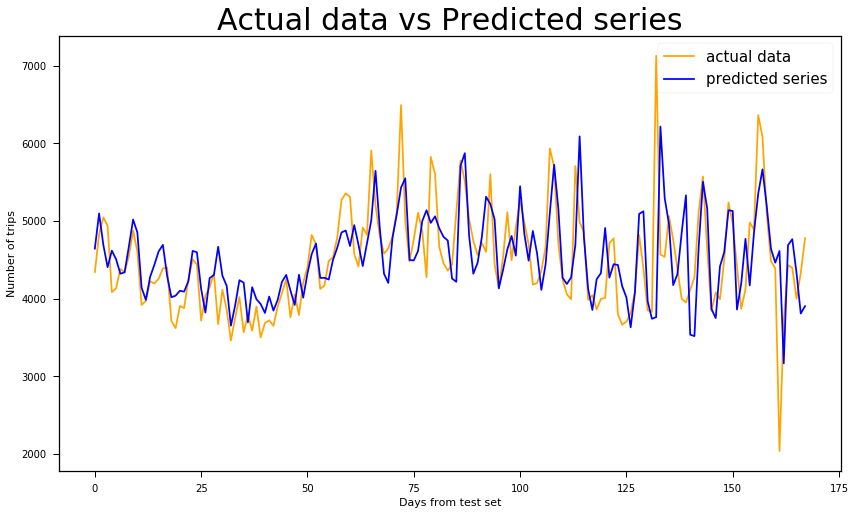

In [27]:
x_range = np.arange(len(y_test))
plt.figure(figsize=(14, 8))
plt.plot(x_range,y_test, c='orange', label='actual data')
plt.plot(x_range,y_pred, c='b', label='predicted series')
plt.legend(fontsize=15)
plt.title('Actual data vs Predicted series', fontsize=30)
plt.xlabel('Days from test set')
plt.ylabel('Number of trips');
